# INFORMASI
Ini adalah proses cleaning dan penyiapan data komentar YouTube non-labeled untuk dipergunakan di bagian Masked Language Modelling. Jadi data hanya sekedar dibersihkan biasa agar siap diterima model BERT.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import re
import string
import html
import unicodedata
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import stanza

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')
import random

## Expand Slang

In [2]:
df = pd.read_csv('../data/comments_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18883 entries, 0 to 18882
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  18883 non-null  object
dtypes: object(1)
memory usage: 147.6+ KB


In [3]:
df_kamus = pd.read_csv('../data/new_kamusalay.csv', encoding='latin1', header=None)
df_kamus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15167 entries, 0 to 15166
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       15167 non-null  object
 1   1       15167 non-null  object
dtypes: object(2)
memory usage: 237.1+ KB


In [4]:
df_kamus = df_kamus.rename(columns={
    0: 'original_text',
    1: 'translate_slang'
})

df_kamus.head()

,original_text,translate_slang
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


## Cek duplicate comments

In [5]:
print("duplicated columns: ", df['comment'].duplicated().sum())
dups = df[df['comment'].duplicated(keep=False)].sort_values("comment")
dups

duplicated columns:  0


,comment


In [6]:
slang_dict = dict(zip(df_kamus['original_text'], df_kamus['translate_slang']))

# sort slang terpanjang dulu agar yang panjang match duluan (mencegah konflik)
'''
Misalkan pny kamus:
gw -> saya
gws -> get well soon
kalau tidak urutkan dari yang panjang dulu, regex akan match "gw" duluan ketika melihat "gws"
'''
slang_keys = sorted(slang_dict.keys(), key=len, reverse=True)
pattern = re.compile(r'\b(' + '|'.join(map(re.escape, slang_keys)) + r')\b', flags=re.IGNORECASE)

def match_case(original, replacement):
    """
    Menyesuaikan replacement agar mengikuti huruf pada original.
    """
    if original.isupper():          # APBN -> ANGGARAN PEMERINTAH
        return replacement.upper()
    elif original[0].isupper():     # Apbn -> Anggaran pemerintah
        return replacement.capitalize()
    else:                           # apbn -> anggaran pemerintah
        return replacement.lower()


def replace_slang(text):
    text = str(text)

    def repl(m):
        orig = m.group(0)             # kata yang muncul di teks
        key = orig.lower()            # samakan format ke lowercase untuk lookup
        replacement = slang_dict[key] # ambil terjemahan dari kamus
        return match_case(orig, replacement)

    return pattern.sub(repl, text)

df['text_expanded'] = df['comment'].apply(replace_slang)

## Panjang komen

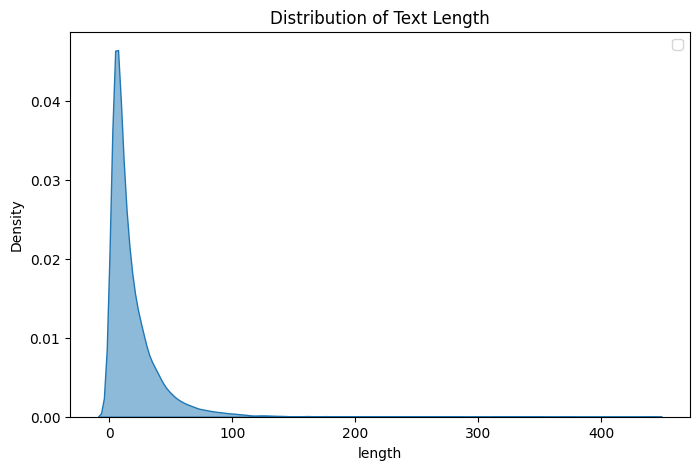

In [7]:
df['length'] = df['text_expanded'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))

sns.kdeplot(df['length'], fill=True, alpha=0.5)

plt.title('Distribution of Text Length')
plt.ylabel('Density')
plt.legend()
plt.show()

In [9]:
df['length'].describe()

count    18883.000000
mean        18.896733
std         24.055648
min          1.000000
25%          5.000000
50%         11.000000
75%         24.000000
max        439.000000
Name: length, dtype: float64

In [7]:
weird_texts = df[df['text_expanded'].apply(lambda x: bool(re.search(r'[^\x00-\x7F]', str(x))))]

for c in weird_texts['text_expanded'].unique():
    print(c)
print('\nJumlah kalimat: ', weird_texts['text_expanded'].nunique())

Mbaer, semangat ya semoga kamu sehat selalu dan bahagia selalu dengan pilihan ini. walaupun orang bilang jangan dinormalisasi memang benar tetapi kamu perlu support.. semangat ya mbaer
💓💓
menonton nya ikut menangis ya Allah yang kuat ya kakak peluk jauh😢
Nangisin mbak er dari kemarin😢
Kalau yang paham bakal cengar cengir melihat ini🤣 kita tunggu 8 agustus ada apa ya geng!💃🏻🤣
amit amit jabang bayi . 
lindungilah anak anak ku ya Allah . 🤲
dunia sudah sangat menakutkan .
Jangan lihat 1 keburukan dengan menjatuhkan 1000 kebaikan . Doakan saja yang terbaik . Kita tidak tau apa yang dialami dikehidupan orang sebenarnya . Please open minded , jangan cuma ikut ikut an buat judge orang ya gess❤❤❤
Semangat ibu hamil...Tuhan Yesus jaga selalu❤
Iya that’si not easy  for er’l  permulaan yang buruk doakan dia semoga baik baik saja . Lebih respect dia tidak membuang kandungan nya ❤  good luck er’l
Masyaallah, rispect !!! ❤❤❤❤
Dari awal sampai akhir menangis terus nih mata..sedih terharu..kuat kuat ya

Problem: 
1. Emot
2. Duplikasi (ViRaLllllll -> Viral)
3. Spasi Berlebih
4. Campur bahasa inggris 
5. Singkatan (bahasa indonesia -> perlu kamus buat expand slang)
6. Pangkat (orang^2 dan orang2)

## Preprocessing

In [8]:
def clean_text_bert(text):

    # Hapus newline dulu
    text = text.replace("\n", " ")

    # 1. Normalisasi unicode
    text = unicodedata.normalize("NFKD", text)
    text = "".join([c for c in text if c.isprintable()])

    # 3. Decode HTML entities
    text = html.unescape(text)

    # 4. Hapus huruf Arab
    text = re.sub(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF]+', ' ', text)

    # 5. Hapus emoji
    emoji_pattern = re.compile(
        "["    
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002700-\U000027BF"
        "\U0001F900-\U0001F9FF"
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(" ", text)

    # 6. Hapus pola hex "xf2", "xe1", dll
    text = re.sub(r'\bx[a-zA-Z0-9]{2}\b', ' ', text)

    # 7. Format tanggal
    text = re.sub(r'(\d{1,2})/([A-Za-z]+?)/(\d{4})', r'\1 \2 \3', text)
    text = re.sub(r'(\d{1,2})/(\d{1,2})/(\d{4})', r'\1 \2 \3', text)

    # 8. Hapus hashtag
    text = re.sub(r'#\S+', '', text)

    # 9. Slash hanya boleh antara angka
    text = re.sub(r'(?<!\d)/(?!\d)', ' ', text)

    # 10a. Pangkat → orang^2 → orang
    text = re.sub(r'\b([A-Za-z]+)\^2\b', r'\1', text)

    # 10b. Pola kata2 → kata
    text = re.sub(r'\b([A-Za-z]+)2\b', r'\1', text)

    # 11. Word elongation (Nabuuunggg → Nabung)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 12. Hapus duplikasi ?! (?? → ?)
    text = re.sub(r'([?!])\1+', r'\1', text)

    # 15. Hapus punctuation KECUALI .,?! dan koma tidak boleh double
    text = re.sub(r'[^0-9A-Za-z.,?!\s]', ' ', text)

    # koma triple / double → jadi 1 koma
    text = re.sub(r',,+', ',', text)

    # koma harus ada spasi setelahnya → “aku,kamu” → “aku, kamu”
    text = re.sub(r',(?=\S)', ', ', text)

    # 16. Hapus titik di luar angka
    text = re.sub(r'(?<!\d)\.(?!\d)', ' ', text)

    # 17. Bersihkan spasi
    text = re.sub(r'\s+', ' ', text).strip()

    return text



df['clean_text_bert'] = df['text_expanded'].apply(lambda x: clean_text_bert(x))

In [9]:
df.head()

,comment,text_expanded,clean_text_bert
0,owh... dia katolik..,oh... dia katolik..,oh dia katolik
1,Kenapa nangis ka?,Kenapa menangis kakak?,Kenapa menangis kakak?
2,maaf seblmnya mba....\nitulah manfaat batasan ...,maaf seblmnya mbak....\nitulah manfaat batasan...,maaf seblmnya mbak itulah manfaat batasan dala...
3,Kukira promo film,Aku kira promo film,Aku kira promo film
4,"iya bener, ku ngefans sm dia, anakku juga, jd...","iya benar, ku menggemari sama dia, anakku jug...","iya benar, ku menggemari sama dia, anakku juga..."


## Output ke TXT File

File : dapt_corpus.txt

In [ ]:
# import csv
# df.to_csv(
#     "../data/dapt_corpus.txt",
#     index=False,
#     header=False,
#     encoding="utf-8"
# )
